# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. The goal of this project is to understand the results of an A/B test run by an e-commerce website, and assist the comopany in deciding on whether they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [151]:
#importing libraries to be used
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [152]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [153]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [154]:
df.nunique(axis=0)

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [155]:
converted = df.query('converted == 1').count()
converted/df.count()

user_id         0.119659
timestamp       0.119659
group           0.119659
landing_page    0.119659
converted       0.119659
dtype: float64

e. The number of times the `new_page` and `treatment` don't match.

In [156]:
df.query("landing_page != 'new_page' and group == 'treatment'").count() + df.query("landing_page == 'new_page' and group != 'treatment'").count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [158]:
df2 = df.query('group == "treatment" and landing_page =="new_page" or group == "control" and landing_page =="old_page"')

In [159]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [160]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [161]:
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [162]:
duplicate = df2[df2.duplicated(subset='user_id')]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [163]:
df2 = df2.drop_duplicates(subset='user_id')
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [164]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [165]:
control = df2.query('group == "control"')
control.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [166]:
treatment = df2.query('group == "treatment"')
treatment.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [167]:
new_page = df2.query('landing_page == "new_page"')
new_page.count()/df2.count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Since the probability that an individual received the new page is 50%, there is equal probability for an individual to receive the old page. In addition, since the control group has a 12.03% conversion rate whereas the treatment group has a lesser conversion rate of 11.89%, we may assume that the new landing page does not increase conversions as much as the old landing page. However, due to potential for bias,  we are unable to say for certain whether this assumption is true.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ Null Hypothesis: p_{old} => p_{new} $$

$$ Alternative Hypothesis: p_{old} < p_{new} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

$p_{new} = df2.converted.mean() = 0.11965919355605512 $

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

$p_{old} = df2.converted.mean() = 0.11965919355605512 $

c. What is $n_{new}$, the number of individuals in the treatment group?

In [168]:
#Obtaining the number of individuals in the treatment group (value of n_new)
n_new = len(treatment)
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [169]:
#Obtaining the number of individuals in the control group (value of n_old)
n_old = len(control)
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [170]:
new_page_converted = np.random.choice([1,0], size=len(treatment), p=[df2.converted.mean(), (1-df2.converted.mean())])

#assigned mean of new_page_converted to p_new
p_new = new_page_converted.mean()
p_new

0.11968894088500448

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [171]:
old_page_converted = np.random.choice([1,0], size=len(control), p=[df2.converted.mean(), (1-df2.converted.mean())])

#assigned mean of old_page_converted to p_old
p_old = old_page_converted.mean()
p_old

0.11875490452524196

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [172]:
p_new - p_old

0.00093403635976252453

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [173]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size=len(treatment), p=[df2.converted.mean(), (1-df2.converted.mean())])
    old_page_converted = np.random.choice([1,0], size=len(control), p=[df2.converted.mean(), (1-df2.converted.mean())])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

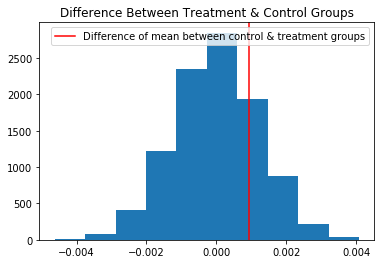

In [226]:
#Assigning the difference of mean between control & treatment groups to a variable called ab_diff
ab_diff = p_new - p_old

plt.hist(p_diffs)
plt.title('Difference Between Treatment & Control Groups')
plt.axvline(x=ab_diff, color='red', label='Difference of mean between control & treatment groups')
plt.legend();

**1. We imported libraries and obtained data from the csv file.**

**2. We cleaned up the data by removing duplicates & mismatched data.**

**3. We stated our hypotheses.**

**4. We computed the difference in conversion rates between the control group and the treatment group in null.**

**5. We simulated a sampling distribution of 10000 from a sample of the original data.**

**6. We obtained the p value.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [175]:
#Obtain the mean of p_diffs
p_diffs = np.array(p_diffs)
p_diffs.mean()

-2.8084722103020541e-06

In [176]:
#obtaining the observed difference
ab_data = treatment.converted.mean() - control.converted.mean()
ab_data

-0.0015782389853555567

In [177]:
#Obtaining the proportion of p_diffs that are greater than the actual difference observed in ab_data
p_diffs.mean() - ab_data

0.0015754305131452546

In [178]:
#obtaining the p-value
(p_diffs > ab_data).mean()

0.90200000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In j, we performed computations to obtain the p-value, which is the probability of observing our statistic (or one of more extreme in favor of the alternative) if the hypothesis is true.**

**Due to the fact that our p-value is high at 0.90, we do not have the evidence to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [179]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page'] == 'old_page'].converted.sum()
convert_new = df2[df2['landing_page'] == 'new_page'].converted.sum()
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [180]:
from statsmodels.stats.proportion import proportions_ztest
counts = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
value = 0.05
z_score, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z-test is a statistical test used to determine whether two population means are different when the variances are known and the sample size is large. Owing to the fact that our null & alternative hypotheses are left-tailed and our significant level being at 95%, our critical value is designated to be -1.64 or 1.64.** 

**A z-score (also called a standard score) gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is. Our z-score indicates that our conversation rate for the new landing page is 1.31 standard deviations above the conversion rate of the old landing page. Since our z-score is within our critical value, we are unable to reject our null hypothesis.**

**The p-value in j is similar to the p-value we have obtained above, further edifying our earlier consensus that we are unable to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since each row is either a conversion or no conversion, we will be performing the logistic regression, which is used when predicting a categorical response from 2 possible outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [181]:
#Create an intercept column for df2
df2['intercept'] = 1

#Create a dummy variable column called ab_page column for which page each user received
df2['ab_page']=0
ab_index = df2[df2['group']=='treatment'].index
df2.loc[ab_index, "ab_page"] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [182]:
logm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logm.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [183]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:51:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value for the ab_page is 0.190, which is higher than the error rate of 0.05, indicating that it is statistically insignificant to determining whether or not the user converts.**

**The part III p-value differs from the part II p-value because in part II, the null hypothesis indicates that the converted rates of old pages were equal to or greater than the converted rates of the new pages whereas the alternative hypothesis indicates that the converted rates of the old pages were less than the converted rates of the new pages.**

**In the part III, we obtained the p-value using logistic regression, which is utilized for instances wherein there are only two outcomes. In the part III p-value, the null hypothesis indicates that the difference between the new landing pages and the old landing pages is zero whereas the alternative hypothesis indicates that the difference between the new landing pages and the old landing pages is *NOT* zero (or greater or lesser than zero). Or put simply...**

$$ Null Hypothesis: p_{old} - p_{new} = 0 $$

$$ Alternative Hypothesis: p_{old} - p_{new} \neq 0 $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding the duration on the landing pages as well as other factors could be beneficial to add into the regression model as it could give us a more precise prediction. The disadvantage of adding too many factors is that it can make our model too complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [198]:
#Read in countries.csv
countries = pd.read_csv('countries.csv')

In [205]:
#Join countries dataframe & df2 dataframe into a new dataframe
df3 = df2.join(countries.set_index('user_id'), on='user_id')

In [207]:
#Create dummy variables for country
df3[['US','UK','CA']] = pd.get_dummies(df3['country'])

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [215]:
#Drop ab_page column and create dummy variables for group column
df3.drop(columns=['ab_page'])
df3[['treatment','control']] = pd.get_dummies(df3['group'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA,treatment,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [216]:
logm = sm.Logit(df3['converted'], df3[['intercept','treatment', 'US','UK']])
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:               2.323e-05
Time:                        10:09:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
treatment      0.0149      0.011      1.307      0.191      -0.007       0.037
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [217]:
#Exponentiate coefficients
np.exp(results.params)

intercept    0.134766
treatment    1.015056
US           0.960062
UK           1.009932
dtype: float64

In [224]:
#Obtain reciprocals for exponentiated coefficients with values that are less than 1. In this case, the US.
1/np.exp(-0.0408)

1.0416437559600236

<a id='conclusions'></a>
**CONCLUSIONS: Based on our logistic regression model, I have come to the following conclusions:**

- When a user is in the treatment group, conversion is 1.01 times as likely than if the user was from the control group, holding all other variables constant.

- When a user is residing in the US, conversion is 1.041 times less likely holding all else constant.

- When a user is residing in the UK, conversion is 1.009 more likely holding all other variables constant.



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [228]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

## Citations:

https://www.investopedia.com/terms/z/z-test.asp

https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/

http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm

https://towardsdatascience.com/demystifying-hypothesis-testing-with-simple-python-examples-4997ad3c5294

